In [2]:
import numpy as np  # Numerical computations
import gym  # RL environment library
from gym import spaces  # Used to define state and action spaces
import matplotlib.pyplot as plt  # Used for visualization and plotting
import pandas as pd  # Used for handling datasets (e.g., weather data)
import random
from collections import deque

In [3]:
class ReplayBuffer:
    """
    Experience replay buffer to store and sample transitions.
    """
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
    
    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """Randomly sample batch of experiences"""
        # Make sure we don't sample more than buffer size
        batch_size = min(batch_size, len(self.buffer))
        
        # Sample random indices
        indices = random.sample(range(len(self.buffer)), batch_size)
        
        # Get samples
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            s, a, r, s_, d = self.buffer[i]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(s_)
            dones.append(d)
        
        return (
            np.array(states), 
            np.array(actions), 
            np.array(rewards).reshape(-1, 1), 
            np.array(next_states),
            np.array(dones).reshape(-1, 1)
        )
    
    def __len__(self):
        """Return current buffer size"""
        return len(self.buffer)
    
    def is_ready(self, batch_size):
        """Check if buffer has enough experiences"""
        return len(self) >= batch_size



In [4]:
class HybridEnergyEnv(gym.Env):
    def __init__(self):
        super(HybridEnergyEnv, self).__init__()

        # Define state and action sizes
        self.state_size = 4  # [P_solar, P_wind, Energy demand, Grid price]
        self.action_size = 3  # [N_pv, N_wt, P_grid]
        self.cost_weight = 0.6
        self.co2_weight = 0.4

        # Action space bounds
        self.action_low = np.array([0, 0, 0])  # Min panels, min turbines, min grid power
        self.action_high = np.array([300, 50, 200])  # Max panels, max turbines, max grid power

        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=self.action_low,
            high=self.action_high,
            dtype=np.float32
        )

        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0]),  # Min values for state
            high=np.array([0.4, 20, 200, 0.1]),  # Max values for state
            dtype=np.float32
        )

        # Emission factors (gCO2/kWh)
        self.EF_PV = 50  # Emission factor per solar panel
        self.EF_WT = 10  # Emission factor per wind turbine
        self.EF_grid = 800  # Emission factor for grid power

        # Initialize state
        self.current_state = None
        self.reset()

    def reset(self):
        """Reset the environment to an initial state."""
        self.current_state = np.array([0, 0, 1000, 0.1])  # Example initial state
        return self.current_state

    def calculate_cost(self, action, state):
        """Calculate the comprehensive cost component of the reward.
        
        Args:
            action (array): Contains [N_pv, N_wt, P_grid] - number of PV panels, 
                            wind turbines, and grid power in kW
            state (array): Contains [P_solar, P_wind, Energy demand, Grid price]
        
        Returns:
            float: Negative cost (reward component)
        """
        # Extract values from action and state
        pv_count, wt_count, grid_power = action
        p_solar, p_wind, energy_demand, grid_price = state
        
        # Calculate actual power generation
        pv_power_per_panel = 0.4  # kW per panel
        wt_power_per_turbine = 20  # kW per turbine
        pv_power = pv_count * p_solar  # p_solar is capacity factor
        wt_power = wt_count * p_wind  # p_wind is capacity factor
        
        # Capital costs (one-time costs amortized over lifetime)
        pv_capex = 1000  # $ per kW
        wt_capex = 1500  # $ per kW
        pv_lifetime = 25 * 365 * 24  # hours (25 years)
        wt_lifetime = 20 * 365 * 24  # hours (20 years)
        
        # Amortized capital costs per hour
        pv_capital_cost = (pv_count * pv_power_per_panel * pv_capex) / pv_lifetime
        wt_capital_cost = (wt_count * wt_power_per_turbine * wt_capex) / wt_lifetime
        
        # Operation and maintenance costs
        pv_om_cost = pv_count * pv_power_per_panel * 0.015  # $0.015 per kW per hour
        wt_om_cost = wt_count * wt_power_per_turbine * 0.025  # $0.025 per kW per hour
        
        # Grid electricity costs (using grid_price from state)
        grid_cost = max(0, grid_power) * grid_price  # Only pay for imported power
        
        # Revenue from excess energy if renewable generation exceeds demand
        renewable_generation = pv_power + wt_power
        excess_energy = max(0, renewable_generation - energy_demand)
        
        # Land use costs
        pv_land_area = pv_count * 8  # 8 m² per panel
        wt_land_area = wt_count * 400  # 400 m² per wind turbine
        land_lease_cost = (pv_land_area + wt_land_area) * 0.0001  # $ per m² per hour
        
        # Total cost calculation
        total_cost = (
            pv_capital_cost + wt_capital_cost +
            pv_om_cost + wt_om_cost +
            grid_cost +
            land_lease_cost
        )
        
        return -total_cost  # Negative as we want to minimize cost
    
    def calculate_co2(self, action, state):
        """Calculate comprehensive CO2 emissions component of the reward.
        
        Args:
            action (array): Contains [N_pv, N_wt, P_grid] - number of PV panels, 
                            wind turbines, and grid power in kW
            state (array): Contains [P_solar, P_wind, Energy demand, Grid price]
        
        Returns:
            float: Negative CO2 emissions (reward component)
        """
        # Extract values from action and state
        pv_count, wt_count, grid_power = action
        p_solar, p_wind, energy_demand, grid_price = state
        
        # Calculate actual power generation
        pv_power_per_panel = 0.4  # kW per panel
        wt_power_per_turbine = 20  # kW per turbine
        pv_power = pv_count * pv_power_per_panel * p_solar  # p_solar is capacity factor
        wt_power = wt_count * wt_power_per_turbine * p_wind  # p_wind is capacity factor
        
        # Convert from gCO2/kWh to kgCO2/kWh for consistency
        ef_pv = self.EF_PV / 1000  # kg CO2/kWh
        ef_wt = self.EF_WT / 1000  # kg CO2/kWh
        ef_grid = self.EF_grid / 1000  # kg CO2/kWh
        
        # Lifecycle emissions from manufacturing and installation
        # Amortized over lifetime of equipment
        pv_lifetime = 25 * 365 * 24  # hours (25 years)
        wt_lifetime = 20 * 365 * 24  # hours (20 years)
        pv_lifecycle_co2 = 40  # kg CO2-eq per kW
        wt_lifecycle_co2 = 11  # kg CO2-eq per kW
        
        # Hourly lifecycle emissions
        pv_manufacturing_co2 = (pv_count * pv_power_per_panel * pv_lifecycle_co2) / pv_lifetime
        wt_manufacturing_co2 = (wt_count * wt_power_per_turbine * wt_lifecycle_co2) / wt_lifetime
        
        # Operational emissions
        pv_op_co2 = pv_power * ef_pv
        wt_op_co2 = wt_power * ef_wt
        grid_co2 = max(0, grid_power) * ef_grid
        
        # Maintenance emissions
        pv_maintenance_co2 = pv_count * 0.0002  # kg CO2 per panel per hour
        wt_maintenance_co2 = wt_count * 0.001  # kg CO2 per turbine per hour
        
        # Total emissions calculation
        total_co2 = (
            pv_manufacturing_co2 + wt_manufacturing_co2 +
            pv_op_co2 + wt_op_co2 +
            pv_maintenance_co2 + wt_maintenance_co2 +
            grid_co2 
        )
        
        return -total_co2  # Negative as we want to minimize emissions
    
    def calculate_reward(self, action, state):
        """Calculate the combined reward from cost and emissions components.
        
        Args:
            action (array): [N_pv, N_wt, P_grid]
            state (array): [P_solar, P_wind, Energy demand, Grid price]
            
        Returns:
            float: Combined reward value
        """
        # Calculate cost and emissions components
        cost_component = self.calculate_cost(action, state)
        co2_component = self.calculate_co2(action, state)
        

        
        # Calculate combined reward
        reward = (self.cost_weight * cost_component) + (self.co2_weight * co2_component)
        
        # Add penalty for not meeting energy demand
        p_solar, p_wind, energy_demand, grid_price = state
        pv_count, wt_count, grid_power = action
        pv_power_per_panel = 0.4  # kW per panel
        wt_power_per_turbine = 20  # kW per turbine
        
        total_generation = (pv_count * p_solar) + \
                           (wt_count * p_wind) + \
                           grid_power
        
        if total_generation < energy_demand:
            # Penalty for not meeting demand
            shortage = energy_demand - total_generation
            demand_penalty = -100 * shortage / energy_demand
            reward += demand_penalty
        
        return reward

    def step(self, action):
        """Execute one time step in the environment."""
        # Extract action components
        N_pv = int(action[0])  # Number of PV panels (integer)
        N_wt = int(action[1])  # Number of wind turbines (integer)
        P_grid_action = action[2]  # Grid power (continuous)
        
        # Extract current state
        P_solar, P_wind, energy_demand, grid_price = self.current_state
        
        # Compute energy generated
        pv_power_per_panel = 0.4  # kW per panel (previously 0.2 * 300W = 60W = 0.06kW)
        wt_power_per_turbine = 20  # kW per turbine (previously 0.5 * 10000W = 5000W = 5kW)
        
        P_pv = N_pv * P_solar   
        P_wt = N_wt * P_wind 
        total_renewable_energy = P_pv + P_wt
        
        # Compute energy deficit and grid usage
        energy_deficit = max(0, energy_demand - total_renewable_energy)
        grid_power_used = min(P_grid_action, energy_deficit)
        
        # Calculate cost and CO2 components using our comprehensive models
        cost_component = self.calculate_cost(action, self.current_state)
        co2_component = self.calculate_co2(action, self.current_state)
        

        # Compute reward using the weighted components
        reward = (self.cost_weight * cost_component) + (self.co2_weight * co2_component)
        
        # Add penalty for not meeting energy demand
        total_generation = total_renewable_energy + grid_power_used
        if total_generation < energy_demand:
            # Penalty for not meeting demand
            shortage = energy_demand - total_generation
            demand_penalty = -100 * shortage / energy_demand
            reward += demand_penalty
        
        # Update state with random fluctuations (keeping your original approach)
        next_P_solar = np.clip(P_solar + np.random.uniform(-50, 50), 0, 1200)
        next_P_wind = np.clip(P_wind + np.random.uniform(-2, 2), 0, 25)
        next_state = np.array([
            next_P_solar,
            next_P_wind,
            energy_demand,  # Demand remains fixed
            grid_price  # Grid price remains fixed
        ])
        
        self.current_state = next_state
        done = False
        
        # Provide additional info for debugging or monitoring
        info = {
            'renewable_energy': total_renewable_energy,
            'grid_energy': grid_power_used,
            'total_energy': total_generation,
            'energy_demand': energy_demand,
            'cost_component': -cost_component,  # Convert back to positive for reporting
            'co2_component': -co2_component,    # Convert back to positive for reporting
            'demand_met': total_generation >= energy_demand
        }
        
        return next_state, reward, done, info


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

class EnhancedQAgent:
    def __init__(self, env, alpha=0.1, gamma=0.98, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.05, max_energy=200):
        self.env = env
        self.max_energy = max_energy
        
        # Reduce action space dimensionality for better learning
        self.n_pv_values = np.arange(0, 301, 10)  # 0 to 300 panels in steps of 10
        self.n_wt_values = np.arange(0, 51, 5)    # 0 to 50 turbines in steps of 5
        self.p_grid_values = np.arange(0, 201, 20)  # 0 to 200 grid power in steps of 20
        
        self.action_space_pv = list(self.n_pv_values)
        self.action_space_wt = list(self.n_wt_values)
        self.action_space_grid = list(self.p_grid_values)
        
        self.pv_size = len(self.action_space_pv)
        self.wt_size = len(self.action_space_wt)
        self.grid_size = len(self.action_space_grid)
        self.action_count = self.pv_size * self.wt_size * self.grid_size
        
        # Use a dictionary for sparse Q-table representation
        self.q_table = {}
        
        # Target network implementation
        self.target_q_table = {}
        self.update_target_counter = 0
        self.target_update_frequency = 10  # Update target network every 10 episodes
        
        # Hyperparameters - improved values
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
        # Track visited states for memory optimization
        self.visited_states = set()
        
        # Track metrics separately
        self.cost_history = []
        self.co2_history = []
        self.energy_violation_history = []
        
    def discretize_state(self, state):
        """Convert continuous state to a discretized key with appropriate granularity."""
        # Increase discretization precision for better state representation
        return tuple(np.round(state, decimals=2))
    
    def action_to_idx(self, action):
        """Convert action tuple to flat index."""
        pv_idx = self.action_space_pv.index(action[0])
        wt_idx = self.action_space_wt.index(action[1])
        grid_idx = self.action_space_grid.index(action[2])
        return pv_idx * (self.wt_size * self.grid_size) + wt_idx * self.grid_size + grid_idx
    
    def idx_to_action(self, idx):
        """Convert flat index to action tuple."""
        grid_idx = idx % self.grid_size
        temp = idx // self.grid_size
        wt_idx = temp % self.wt_size
        pv_idx = temp // self.wt_size
        
        return (self.action_space_pv[pv_idx],
                self.action_space_wt[wt_idx],
                self.action_space_grid[grid_idx])
    
    def estimate_total_energy(self, action, state):
        """Estimate the total energy generated by the given action."""
        pv_count, wt_count, grid_power = action
        
        pv_power = state[0]  #power factor
        wind_power = state[1]  # Wind power factor
        
        # Simplified energy calculations
        pv_energy = pv_count * pv_power
        wt_energy = wt_count * wind_power
        
        total_energy = pv_energy + wt_energy + grid_power
        return total_energy
        
    def get_valid_action(self, action, state):
        """Adjust the action to ensure total energy doesn't exceed the maximum limit."""
        pv_count, wt_count, grid_power = action
        total_energy = self.estimate_total_energy(action, state)
        
        if total_energy <= self.max_energy:
            return action  # Action is already valid
        
        # We need to reduce energy - prioritize reducing grid power first
        excess_energy = total_energy - self.max_energy
        adjusted_grid = max(0, grid_power - excess_energy)
        
        # Find the closest valid grid power value in our discretized space
        adjusted_grid = min(self.action_space_grid, key=lambda x: abs(x - adjusted_grid))
        
        adjusted_action = (pv_count, wt_count, adjusted_grid)
        
        # Verify the adjustment worked
        if self.estimate_total_energy(adjusted_action, state) > self.max_energy:
            # If still over limit, find the most conservative valid action
            for g in self.action_space_grid:
                test_action = (pv_count, wt_count, g)
                if self.estimate_total_energy(test_action, state) <= self.max_energy:
                    return test_action
            
            # If no valid action found with current PV/WT, reduce them
            return (0, 0, min(self.action_space_grid, key=lambda x: x if x <= self.max_energy else float('inf')))
        
        return adjusted_action
    
    def choose_action(self, state):
        """Epsilon-greedy policy for action selection with energy constraint."""
        state = self.discretize_state(state)
        
        # Explore: Randomly sample from action space components
        if np.random.rand() < self.epsilon:
            pv = random.choice(self.action_space_pv)
            wt = random.choice(self.action_space_wt)
            grid = random.choice(self.action_space_grid)
            action = (pv, wt, grid)
            return self.get_valid_action(action, state)  # Ensure action meets energy constraint
        
        # Exploit: Use the best known action
        if state not in self.q_table:
            # Initialize on-demand with a single random action
            self.q_table[state] = {0: 0.0}
            action = self.idx_to_action(0)
            return self.get_valid_action(action, state)  # Ensure action meets energy constraint
        
        # Find best action index
        best_idx = max(self.q_table[state], key=self.q_table[state].get)
        action = self.idx_to_action(best_idx)
        return self.get_valid_action(action, state)  # Ensure action meets energy constraint
    
    def update_target_network(self):
        """Update the target network with the current Q-table values."""
        self.target_q_table = {state: dict(values) for state, values in self.q_table.items()}
    
    def update_q_table(self, state, action, reward, cost, co2, next_state):
        """Update Q-table using the Q-learning formula with sparse representation."""
        state = self.discretize_state(state)
        next_state = self.discretize_state(next_state)
        
        # Convert action to index - handle non-discretized values
        try:
            pv = min(self.action_space_pv, key=lambda x: abs(x - action[0]))
            wt = min(self.action_space_wt, key=lambda x: abs(x - action[1]))
            grid = min(self.action_space_grid, key=lambda x: abs(x - action[2]))
            mapped_action = (pv, wt, grid)
            action_idx = self.action_to_idx(mapped_action)
        except ValueError:
            # Fallback if conversion fails
            action_idx = 0
        
        # Initialize state entry if new
        if state not in self.q_table:
            self.q_table[state] = {}
        
        # Initialize action value if new
        if action_idx not in self.q_table[state]:
            self.q_table[state][action_idx] = 0.0
        
        # Add to visited states
        self.visited_states.add(state)
        
        # Find maximum Q-value for next state using target network
        if next_state in self.target_q_table and self.target_q_table[next_state]:
            best_next_q = max(self.target_q_table[next_state].values())
        else:
            best_next_q = 0.0
        
        # Update rule
        self.q_table[state][action_idx] += self.alpha * (
            reward + self.gamma * best_next_q - self.q_table[state][action_idx]
        )
        
        # Remove near-zero Q-values to save memory
        if abs(self.q_table[state][action_idx]) < 1e-6:
            del self.q_table[state][action_idx]
            # Remove empty state entries
            if not self.q_table[state]:
                del self.q_table[state]
    
    def train(self, episodes=2000, max_steps=15000, cost_weight=0.5, co2_weight=0.5):
        """Train the agent with separate tracking of cost and CO2 metrics."""
        rewards = []
        cost_history = []
        co2_history = []
        energy_violations = []
        
        # Initialize target network
        self.update_target_network()
        
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            episode_violations = 0
            episode_cost = 0
            episode_co2 = 0
            
            for step in range(max_steps):
                action = self.choose_action(state)
                
                # Check if original action would violate energy constraint
                total_energy = self.estimate_total_energy(action, state)
                if total_energy > self.max_energy:
                    episode_violations += 1
                
                # Calculate individual reward components
                cost = env.calculate_cost(action, state)
                co2 = env.calculate_co2(action, state)
                
                # Combined reward with weights
                reward = (env.cost_weight * cost) + (env.co2_weight * co2)
                
                # Additional penalty for actions that would exceed energy limit
                if total_energy > self.max_energy:
                    energy_penalty = -abs(total_energy - self.max_energy) * 0.1  # Scale penalty by excess
                    reward += energy_penalty
                
                next_state, env_reward, done, _ = self.env.step(action)
                
                # Update Q-table with our calculated reward
                self.update_q_table(state, action, reward, cost, co2, next_state)
                
                state = next_state
                total_reward += reward
                episode_cost += cost
                episode_co2 += co2
                
                if done:
                    break
            
            # Update target network periodically
            self.update_target_counter += 1
            if self.update_target_counter % self.target_update_frequency == 0:
                self.update_target_network()
            
            # Decay epsilon faster than before
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            
            # Record metrics
            rewards.append(total_reward)
            cost_history.append(episode_cost)
            co2_history.append(episode_co2)
            energy_violations.append(episode_violations)
            
            # Print progress less frequently
            if episode % 20 == 0:
                print(f"Episode {episode}, Reward: {total_reward:.2f}, Cost: {episode_cost:.2f}, CO2: {episode_co2:.2f}, Violations: {episode_violations}")
        
        self.cost_history = cost_history
        self.co2_history = co2_history
        self.energy_violation_history = energy_violations
        
        print(f"Training complete. Final epsilon: {self.epsilon:.4f}")
        print(f"Final Q-table size: {len(self.q_table)} states")
        
        return rewards, cost_history, co2_history, energy_violations

In [6]:
def test_agent(agent, episodes=100, max_steps=5000):
    """Test the trained agent with separate tracking of cost and CO2 metrics."""
    # Save exploration rate and set to minimum for testing
    original_epsilon = agent.epsilon
    agent.epsilon = agent.min_epsilon
    
    total_rewards = []
    cost_values = []
    co2_values = []
    violations = 0
    
    for episode in range(episodes):
        state = agent.env.reset()
        total_reward = 0
        episode_violations = 0
        episode_cost = 0
        episode_co2 = 0
        
        for step in range(max_steps):
            action = agent.choose_action(state)
            
            # Check for energy violations
            total_energy = agent.estimate_total_energy(action, state)
            if total_energy > agent.max_energy:
                episode_violations += 1
            
            # Calculate individual metrics
            cost = agent.env.calculate_cost(action, state)
            co2 = agent.env.calculate_co2(action, state)
            
            state, env_reward, done, _ = agent.env.step(action)
            
            # Use our calculated reward
            reward = env.cost_weight * cost + env.co2_weight * co2
            
            total_reward += reward
            episode_cost += cost
            episode_co2 += co2
            
            if done:
                break
        
        violations += episode_violations
        total_rewards.append(total_reward)
        cost_values.append(episode_cost)
        co2_values.append(episode_co2)
        
        if episode % 5 == 0:
            print(f"Test episode {episode}: Reward={total_reward:.2f}, Cost={episode_cost:.2f}, CO2={episode_co2:.2f}, Violations={episode_violations}")
    
    # Restore original exploration rate
    agent.epsilon = original_epsilon
    
    print(f"Testing complete. Average reward: {np.mean(total_rewards):.2f}")
    print(f"Average cost: {np.mean(cost_values):.2f}, Average CO2: {np.mean(co2_values):.2f}")
    print(f"Total violations: {violations}")
    
    return np.mean(total_rewards), np.mean(cost_values), np.mean(co2_values), violations

In [7]:
def naive_strategy(env, episodes=200, max_steps=5000, max_energy=200):
    """Industry standard heuristic-based strategy for energy management.
    Uses rule-based decision making with some adaptability."""
    total_rewards = []
    cost_values = []
    co2_values = []
    violations = 0
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_violations = 0
        episode_cost = 0
        episode_co2 = 0
        
        for step in range(max_steps):
            # Get current state values
            pv_factor = state[0]  # Solar power factor
            wind_factor = state[1]  # Wind power factor
            
            # Rule-based decision making based on renewable conditions
            # If good renewable conditions, use more renewable sources
            if pv_factor > 0.6:  # Good solar conditions
                pv_panels = 200  # High solar utilization
            elif pv_factor > 0.3:  # Medium solar conditions
                pv_panels = 150  # Medium solar utilization
            else:  # Poor solar conditions
                pv_panels = 50   # Minimal solar utilization
            
            if wind_factor > 0.7:  # Good wind conditions
                wind_turbines = 35  # High wind utilization
            elif wind_factor > 0.4:  # Medium wind conditions
                wind_turbines = 20  # Medium wind utilization
            else:  # Poor wind conditions
                wind_turbines = 5   # Minimal wind utilization
            
            # Calculate expected renewable energy
            renewable_energy = (pv_panels * pv_factor) + (wind_turbines * wind_factor)
            
            # Determine grid power needed to meet demand
            # Industry typically aims for ~10% buffer over estimated need
            grid_power = max(0, min(1000, (max_energy - renewable_energy) * 1.1))
            
            # Round to nearest grid power increment
            grid_power = round(grid_power / 50) * 50
            
            # Final action
            action = (pv_panels, wind_turbines, grid_power)
            
            # Check for energy constraint violation
            total_energy = pv_panels * pv_factor + wind_turbines * wind_factor + grid_power
            if total_energy > max_energy:
                # Adjust grid power down
                excess = total_energy - max_energy
                adjusted_grid = max(0, grid_power - excess)
                # Round to nearest increment
                adjusted_grid = round(adjusted_grid / 50) * 50
                action = (pv_panels, wind_turbines, adjusted_grid)
                episode_violations += 1
            
            # Calculate metrics
            cost = env.calculate_cost(action, state)
            co2 = env.calculate_co2(action, state)
            
            # Combined reward
            reward = env.cost_weight * cost + env.co2_weight * co2
            
            state, env_reward, done, _ = env.step(action)
            
            total_reward += reward
            episode_cost += cost
            episode_co2 += co2
            
            if done:
                break
        
        violations += episode_violations
        total_rewards.append(total_reward)
        cost_values.append(episode_cost)
        co2_values.append(episode_co2)
    
    avg_reward = np.mean(total_rewards)
    avg_cost = np.mean(cost_values)
    avg_co2 = np.mean(co2_values)
    
    print(f"Industry standard strategy. Average reward: {avg_reward:.2f}")
    print(f"Average cost: {avg_cost:.2f}, Average CO2: {avg_co2:.2f}")
    print(f"Total violations: {violations}")
    
    return avg_reward, avg_cost, avg_co2, violations

In [8]:
# Initialize Environment and Agent
env = HybridEnergyEnv()  # Assuming this class is defined elsewhere
agent = EnhancedQAgent(env, max_energy=200, alpha=0.1, epsilon_decay=0.995)

# Training with tracking of cost and CO2 separately
print("Training the Q-learning agent...")
rewards, cost_history, co2_history, violations_history = agent.train(episodes=2000, max_steps=15000)

# Testing with separate metrics
print("\nTesting the trained Q-learning agent...")
agent_reward, agent_cost, agent_co2, agent_violations = test_agent(agent, episodes=100)

# Test naive strategy with separate metrics
print("\nTesting naive strategy...")
naive_reward, naive_cost, naive_co2, naive_violations = naive_strategy(env, episodes=500, max_energy=200)

# Calculate percentage improvements
cost_improvement = ((naive_cost - agent_cost) / abs(naive_cost)) * 100
co2_improvement = ((naive_co2 - agent_co2) / abs(naive_co2)) * 100
violations_improvement = ((naive_violations - agent_violations) / (naive_violations + 1)) * 100  # Add 1 to avoid division by zero

print("\nPerformance Comparison:")
print(f"Cost improvement: {cost_improvement:.2f}%")
print(f"CO2 emissions improvement: {co2_improvement:.2f}%")
print(f"Energy violations improvement: {violations_improvement:.2f}%")

C:\Users\Yassine Lahniche\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Training the Q-learning agent...
Episode 0, Reward: -13573.60, Cost: -6331.32, CO2: -24437.02, Violations: 0
Episode 20, Reward: -15739.33, Cost: -8064.18, CO2: -27252.05, Violations: 0
Episode 40, Reward: -11749.66, Cost: -6288.95, CO2: -19940.68, Violations: 2
Episode 60, Reward: -10599.04, Cost: -5422.62, CO2: -18363.64, Violations: 1
Episode 80, Reward: -9532.20, Cost: -4562.75, CO2: -16986.36, Violations: 0
Episode 100, Reward: -7504.40, Cost: -3411.99, CO2: -13642.83, Violations: 1
Episode 120, Reward: -8789.46, Cost: -4810.26, CO2: -14758.27, Violations: 0
Episode 140, Reward: -4383.74, Cost: -2202.38, CO2: -7655.77, Violations: 0
Episode 160, Reward: -7688.82, Cost: -4065.41, CO2: -13123.94, Violations: 0
Episode 180, Reward: -8311.71, Cost: -4416.63, CO2: -14154.31, Violations: 0
Episode 200, Reward: -4273.01, Cost: -2236.16, CO2: -7328.28, Violations: 0
Episode 220, Reward: -5450.93, Cost: -2773.72, CO2: -9466.74, Violations: 1
Episode 240, Reward: -4328.82, Cost: -2142.35, C

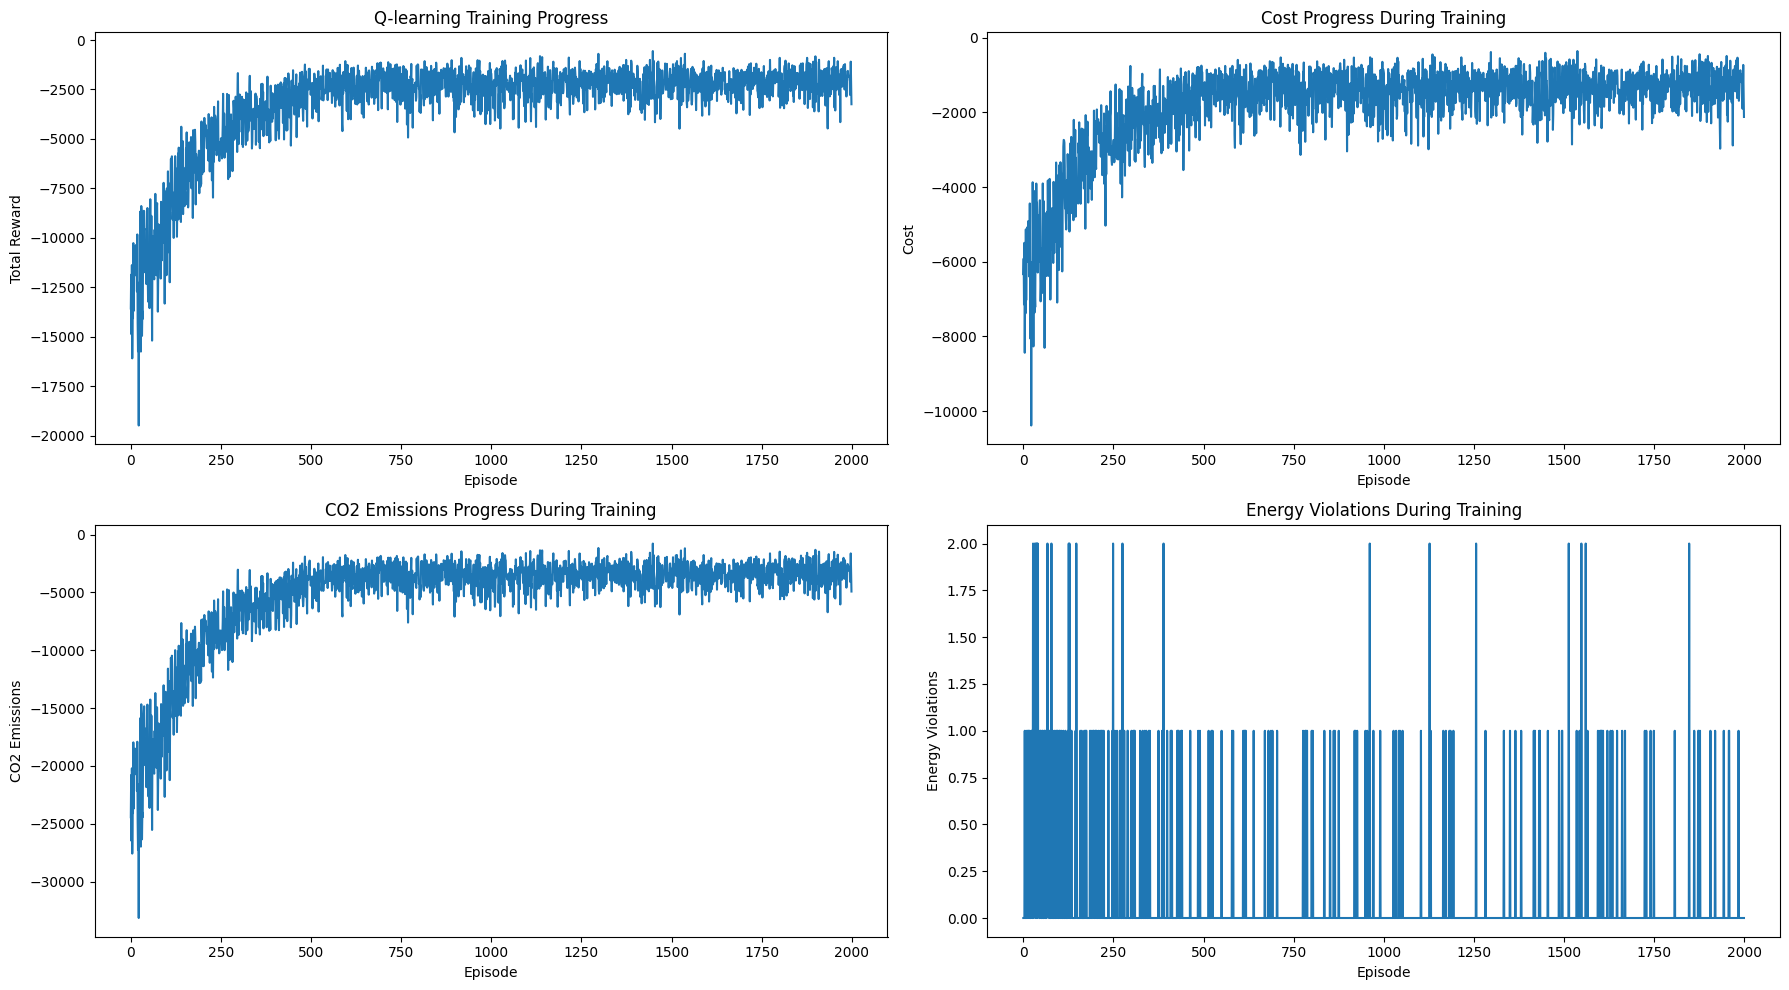

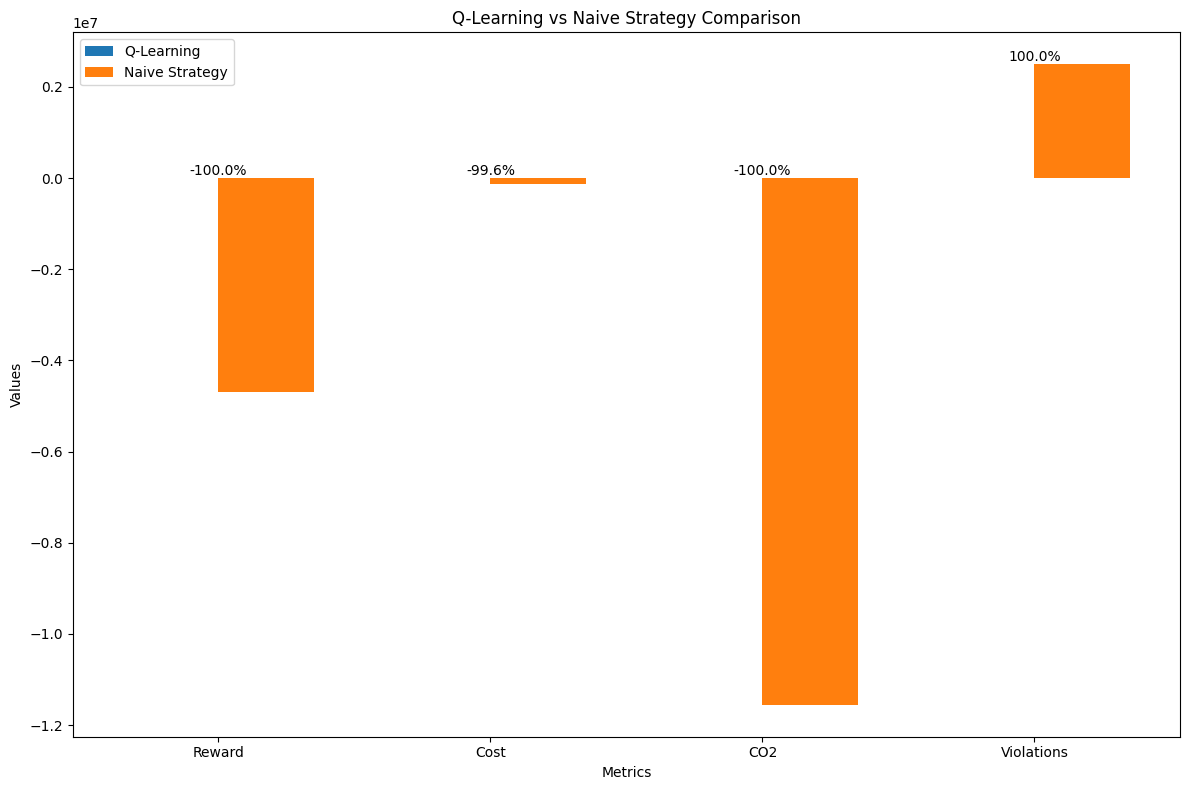

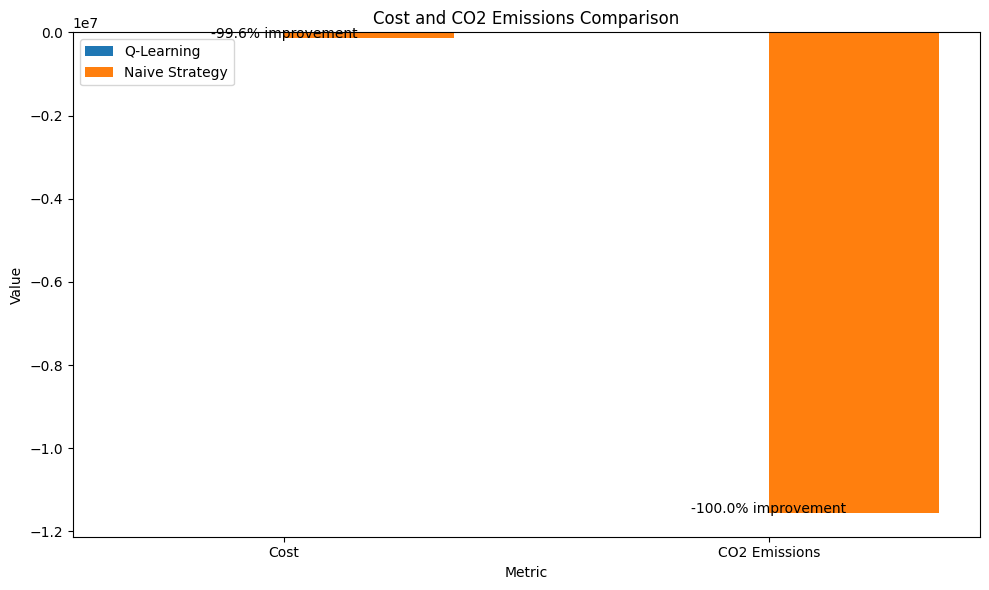

In [11]:
# Plot Training Progress
plt.figure(figsize=(18, 10))

# Plot 1: Overall rewards
plt.subplot(2, 2, 1)
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning Training Progress")

# Plot 2: Cost history
plt.subplot(2, 2, 2)
plt.plot(cost_history)
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.title("Cost Progress During Training")

# Plot 3: CO2 history
plt.subplot(2, 2, 3)
plt.plot(co2_history)
plt.xlabel("Episode")
plt.ylabel("CO2 Emissions")
plt.title("CO2 Emissions Progress During Training")

# Plot 4: Energy violations
plt.subplot(2, 2, 4)
plt.plot(violations_history)
plt.xlabel("Episode")
plt.ylabel("Energy Violations")
plt.title("Energy Violations During Training")

plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()

# Plot comparison between Q-learning and naive strategy
plt.figure(figsize=(12, 8))

# Metrics to compare
metrics = ['Reward', 'Cost', 'CO2', 'Violations']
q_learning_values = [agent_reward, agent_cost, agent_co2, agent_violations]
naive_values = [naive_reward, naive_cost, naive_co2, naive_violations]

# Calculate percentage improvements for all metrics
improvements = []
for q_val, naive_val in zip(q_learning_values, naive_values):
    if naive_val != 0:
        imp = ((naive_val - q_val) / abs(naive_val)) * 100
    else:
        imp = 0 if q_val == 0 else 100
    improvements.append(imp)

# Plot bar chart
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, q_learning_values, width, label='Q-Learning')
plt.bar(x + width/2, naive_values, width, label='Naive Strategy')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Q-Learning vs Naive Strategy Comparison')
plt.xticks(x, metrics)
plt.legend()

# Add improvement percentages as text
for i, imp in enumerate(improvements):
    plt.text(i, max(q_learning_values[i], naive_values[i]) + 0.1, 
             f"{imp:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

# Plot comparison of cost and CO2 separately
plt.figure(figsize=(10, 6))

# Set up data for side-by-side comparison
labels = ['Cost', 'CO2 Emissions']
q_learning_metrics = [agent_cost, agent_co2]
naive_metrics = [naive_cost, naive_co2]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, q_learning_metrics, width, label='Q-Learning')
plt.bar(x + width/2, naive_metrics, width, label='Naive Strategy')

plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Cost and CO2 Emissions Comparison')
plt.xticks(x, labels)
plt.legend()

# Add improvement percentages
plt.text(0, min(agent_cost, naive_cost) - 5, f"{cost_improvement:.1f}% improvement", ha='center')
plt.text(1, min(agent_co2, naive_co2) - 5, f"{co2_improvement:.1f}% improvement", ha='center')

plt.tight_layout()
plt.savefig("cost_co2_comparison.png")
plt.show()

In [12]:
def visualize_agent_performance(agent, env, rewards_history, episodes=5, max_steps=20, sample_size=100):

    # Calculate average contribution of each energy source
    avg_pv_energy = np.mean(test_data['pv_energy'])
    avg_wt_energy = np.mean(test_data['wt_energy'])
    avg_grid_energy = np.mean(test_data['grid'])
    total_avg = avg_pv_energy + avg_wt_energy + avg_grid_energy

    # Create energy mix pie chart
    energy_sources = ['PV Panels', 'Wind Turbines', 'Grid']
    energy_values = [avg_pv_energy, avg_wt_energy, avg_grid_energy]

    plt.pie(energy_values, labels=energy_sources, autopct='%1.1f%%',
            startangle=90, shadow=True, explode=(0.05, 0.05, 0.05),
            colors=['gold', 'skyblue', 'lightgreen'])
    plt.title(f'Average Energy Source Mix\nTotal: {total_avg:.1f} units')



In [17]:
def get_best_actions(agent, states):
    """
    Get the best actions for multiple states using the trained Q-table,
    ensuring demand is always met while minimizing grid usage.
    
    Parameters:
    - agent: The QAgent instance
    - states: List of states to evaluate
    
    Returns:
    - Dictionary mapping each state to its best action tuple (pv, wt, grid)
    """
    best_actions = {}
    for state in states:
        state_key = agent.discretize_state(state)  # Convert to discrete form
        demand = state[2]  # Extract demand from state
        pv_power = state[0]  # Available PV power per unit
        wind_power = state[1]  # Available wind power per unit
        
        # Get best renewable action from Q-table if available
        if state_key in agent.q_table and agent.q_table[state_key]:
            best_idx = max(agent.q_table[state_key], key=agent.q_table[state_key].get)
            pv_count, wt_count, _ = agent.idx_to_action(best_idx)  # Ignore grid from Q-table
        else:
            # Fallback to a random action for renewables if state is not in Q-table
            pv_count = random.choice(agent.action_space_pv)
            wt_count = random.choice(agent.action_space_wt)
        
        # Calculate energy from renewables with the selected action
        pv_energy = pv_count * pv_power
        wt_energy = wt_count * wind_power
        renewable_energy = pv_energy + wt_energy
        
        # Calculate exact grid power needed to meet demand
        required_grid_power = max(0, demand - renewable_energy)
        
        # Find the grid action value that is closest to but not less than required
        grid_options = sorted(agent.action_space_grid)
        
        # Find the smallest grid value that meets the requirement
        selected_grid = None
        for grid_option in grid_options:
            if grid_option >= required_grid_power:
                selected_grid = grid_option
                break
                
        # If no grid option is large enough, take the maximum available
        if selected_grid is None:
            selected_grid = max(grid_options)
            
            # If even max grid plus renewables doesn't meet demand, 
            # try to increase renewable usage
            if renewable_energy + selected_grid < demand:
                # Sort renewable options by energy production (highest first)
                pv_options = sorted([(p, p * pv_power) for p in agent.action_space_pv], 
                                   key=lambda x: x[1], reverse=True)
                wt_options = sorted([(w, w * wind_power) for w in agent.action_space_wt], 
                                   key=lambda x: x[1], reverse=True)
                
                # Try different combinations to minimize excess while meeting demand
                best_excess = float('inf')
                best_combo = (pv_count, wt_count, selected_grid)
                
                for p, p_energy in pv_options:
                    for w, w_energy in wt_options:
                        combined_energy = p_energy + w_energy + selected_grid
                        if combined_energy >= demand:
                            excess = combined_energy - demand
                            if excess < best_excess:
                                best_excess = excess
                                best_combo = (p, w, selected_grid)
                
                pv_count, wt_count, selected_grid = best_combo
        
        # Create the final action with exact grid power needed
        best_actions[tuple(state)] = (pv_count, wt_count, selected_grid)
    
    return best_actions

In [18]:
# Generate 20 diverse example states
import numpy as np

# Generate random states with different solar irradiance, wind speed, and demand levels
np.random.seed(42)  # For reproducibility

# Create states with varying conditions
test_states = []
for _ in range(20):
    solar = round(np.random.uniform(0, 0.4), 2)  # Solar irradiance between 0.1 and 1.0
    wind = round(np.random.uniform(0, 20), 2)   # Wind speed between 0.1 and 1.0
    demand = 200
    test_states.append([solar, wind, demand])

# Get best actions
best_actions = get_best_actions(agent, test_states)

# Print results
for state, action in best_actions.items():
    solar = state[0]
    wind = state[1]
    demand = state[2]

    pv_energy = action[0] *  solar
    wt_energy = action[1] *  wind
    renewable_energy = pv_energy + wt_energy
    grid_energy = action[2]
    total_energy = renewable_energy + grid_energy

    print(f"State: Solar={solar:.2f}, Wind={wind:.2f}, Demand={demand}")
    print(f"  Action: PV panels={action[0]}, Wind turbines={action[1]}, Grid power={action[2]}")
    print(f"  Renewable energy: {renewable_energy:.2f}")
    print(f"  Grid energy: {grid_energy:.2f}")
    print(f"  Total energy: {total_energy:.2f}")
    print(f"  Demand met: {'Yes' if total_energy >= demand else 'No'}")
    print(f"  Excess energy: {max(0, total_energy - demand):.2f}")
    print()

# Summary stats
demand_met_count = sum(1 for state, action in best_actions.items()
                      if agent.estimate_total_energy(action, state) >= state[2])
print(f"Demand met in {demand_met_count} out of {len(test_states)} states ({demand_met_count/len(test_states)*100:.1f}%)")

# Calculate average excess energy
avg_excess = sum(max(0, agent.estimate_total_energy(action, state) - state[2])
                for state, action in best_actions.items()) / len(test_states)
print(f"Average excess energy: {avg_excess:.2f}")

# Calculate average renewable vs grid usage
avg_renewable = sum((action[0] *  state[0] + action[1] *  state[1])
                   for state, action in best_actions.items()) / len(test_states)
avg_grid = sum(action[2] for state, action in best_actions.items()) / len(test_states)
print(f"Average renewable energy: {avg_renewable:.2f}")
print(f"Average grid energy: {avg_grid:.2f}")
print(f"Renewable percentage: {avg_renewable/(avg_renewable+avg_grid)*100:.1f}%")

State: Solar=0.15, Wind=19.01, Demand=200
  Action: PV panels=60, Wind turbines=40, Grid power=0
  Renewable energy: 769.40
  Grid energy: 0.00
  Total energy: 769.40
  Demand met: Yes
  Excess energy: 569.40

State: Solar=0.29, Wind=11.97, Demand=200
  Action: PV panels=80, Wind turbines=10, Grid power=60
  Renewable energy: 142.90
  Grid energy: 60.00
  Total energy: 202.90
  Demand met: Yes
  Excess energy: 2.90

State: Solar=0.06, Wind=3.12, Demand=200
  Action: PV panels=160, Wind turbines=50, Grid power=40
  Renewable energy: 165.60
  Grid energy: 40.00
  Total energy: 205.60
  Demand met: Yes
  Excess energy: 5.60

State: Solar=0.02, Wind=17.32, Demand=200
  Action: PV panels=70, Wind turbines=30, Grid power=0
  Renewable energy: 521.00
  Grid energy: 0.00
  Total energy: 521.00
  Demand met: Yes
  Excess energy: 321.00

State: Solar=0.24, Wind=14.16, Demand=200
  Action: PV panels=170, Wind turbines=20, Grid power=0
  Renewable energy: 324.00
  Grid energy: 0.00
  Total energy:

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

def compare_agents_detailed(agent1, test_states, env, naive_strategy):
    """
    Compare performance of a trained RL agent against a naive rule-based strategy
    on the same set of test states, including cost and CO2 emissions analysis.
    
    Parameters:
    - agent1: The trained RL agent
    - test_states: List of states to evaluate both agents on
    - env: Environment object for the naive strategy
    - naive_strategy: Function implementing the naive strategy
    
    Returns:
    - Dictionary with comparative results
    """
    # Get best actions for the RL agent
    rl_best_actions = get_best_actions(agent1, test_states)
    
    # Run naive strategy
    naive_reward, naive_cost, naive_co2, naive_violations = naive_strategy(env, episodes=1, max_steps=len(test_states))
    
    # Apply naive strategy to the same test states for direct comparison
    naive_best_actions = {}
    
    # For each test state, compute what the naive strategy would do
    for state in test_states:
        pv_factor = state[0]/0.4  # Solar power factor
        wind_factor = state[1]/20  # Wind power factor
        demand = state[2]  # Energy demand
        grid_price = 0.10  # Default grid price if not in state
        
        # Extend state with grid price if needed
        if len(state) < 4:
            state_with_price = list(state) + [grid_price]
        else:
            state_with_price = state
            grid_price = state[3]
        
        # Apply naive strategy rules
        if pv_factor > 0.6:
            pv_panels = 200
        elif pv_factor > 0.3:
            pv_panels = 150
        else:
            pv_panels = 50
        
        if wind_factor > 0.7:
            wind_turbines = 35
        elif wind_factor > 0.4:
            wind_turbines = 20
        else:
            wind_turbines = 5
        
        # Calculate expected renewable energy
        renewable_energy = (pv_panels * pv_factor) + (wind_turbines * wind_factor)
        
        # Determine grid power with 10% buffer
        grid_power = max(0, min(1000, (demand - renewable_energy) * 1.1))
        grid_power = round(grid_power / 50) * 50
        
        # Check for energy constraint violation
        total_energy = pv_panels * pv_factor + wind_turbines * wind_factor + grid_power
        if total_energy > demand:
            # Adjust grid power down
            excess = total_energy - demand
            adjusted_grid = max(0, grid_power - excess)
            # Round to nearest increment
            adjusted_grid = round(adjusted_grid / 50) * 50
            naive_action = (pv_panels, wind_turbines, adjusted_grid)
        else:
            naive_action = (pv_panels, wind_turbines, grid_power)
            
        naive_best_actions[tuple(state_with_price)] = naive_action
    
    # Calculate detailed metrics for both agents
    rl_metrics = []
    naive_metrics = []
    
    for i, state in enumerate(test_states):
        # Ensure state has grid price
        if len(state) < 4:
            state_with_price = list(state) + [0.10]  # Default grid price
        else:
            state_with_price = state
        
        state_tuple = tuple(state_with_price)
        
        # Get actions for this state
        if state_tuple in rl_best_actions:
            rl_action = rl_best_actions[state_tuple]
        else:
            # If the state with price isn't in rl_best_actions, try without price
            original_state_tuple = tuple(state)
            if original_state_tuple in rl_best_actions:
                rl_action = rl_best_actions[original_state_tuple]
            else:
                # Fallback to default action
                rl_action = (100, 10, 100)
        
        naive_action = naive_best_actions[state_tuple]
        
        # Calculate cost and CO2 for RL agent
        rl_cost = -env.calculate_cost(rl_action, state_with_price)  # Negate because function returns negative cost
        rl_co2 = -env.calculate_co2(rl_action, state_with_price)    # Negate because function returns negative CO2
        
        # Calculate cost and CO2 for naive agent
        naive_cost = -env.calculate_cost(naive_action, state_with_price)
        naive_co2 = -env.calculate_co2(naive_action, state_with_price)
        
        # Calculate energy production for RL agent
        solar = state[0]
        wind = state[1]
        demand = state[2]
        
        rl_pv_energy = rl_action[0] * solar
        rl_wt_energy = rl_action[1] * wind
        rl_renewable_energy = rl_pv_energy + rl_wt_energy
        rl_grid_energy = rl_action[2]
        rl_total_energy = rl_renewable_energy + rl_grid_energy
        rl_excess = max(0, rl_total_energy - demand)
        rl_demand_met = rl_total_energy >= demand
        
        # Calculate energy production for naive strategy
        naive_pv_energy = naive_action[0] * solar
        naive_wt_energy = naive_action[1] * wind
        naive_renewable_energy = naive_pv_energy + naive_wt_energy
        naive_grid_energy = naive_action[2]
        naive_total_energy = naive_renewable_energy + naive_grid_energy
        naive_excess = max(0, naive_total_energy - demand)
        naive_demand_met = naive_total_energy >= demand
        
        # Store metrics for each state
        rl_metrics.append({
            'state_index': i,
            'solar': solar,
            'wind': wind,
            'demand': demand,
            'pv_panels': rl_action[0],
            'wind_turbines': rl_action[1],
            'grid_power': rl_action[2],
            'pv_energy': rl_pv_energy,
            'wt_energy': rl_wt_energy,
            'renewable_energy': rl_renewable_energy,
            'grid_energy': rl_grid_energy,
            'total_energy': rl_total_energy,
            'excess_energy': rl_excess,
            'demand_met': rl_demand_met,
            'cost': rl_cost,
            'co2': rl_co2,
            'renewable_percentage': rl_renewable_energy / rl_total_energy * 100 if rl_total_energy > 0 else 0
        })
        
        naive_metrics.append({
            'state_index': i,
            'solar': solar,
            'wind': wind,
            'demand': demand,
            'pv_panels': naive_action[0],
            'wind_turbines': naive_action[1],
            'grid_power': naive_action[2],
            'pv_energy': naive_pv_energy,
            'wt_energy': naive_wt_energy,
            'renewable_energy': naive_renewable_energy,
            'grid_energy': naive_grid_energy,
            'total_energy': naive_total_energy,
            'excess_energy': naive_excess,
            'demand_met': naive_demand_met,
            'cost': naive_cost,
            'co2': naive_co2,
            'renewable_percentage': naive_renewable_energy / naive_total_energy * 100 if naive_total_energy > 0 else 0
        })
    
    # Print detailed results
    print("\n=== COMPARATIVE ANALYSIS: RL AGENT VS NAIVE STRATEGY ===\n")
    
    # Print detailed results for each state
    print("DETAILED STATE ANALYSIS:")
    for i, (rl_metric, naive_metric) in enumerate(zip(rl_metrics, naive_metrics)):
        print(f"\nState {i+1}: Solar={rl_metric['solar']:.2f}, Wind={rl_metric['wind']:.2f}, Demand={rl_metric['demand']}")
        
        print("  RL Agent:")
        print(f"    Action: PV panels={rl_metric['pv_panels']}, Wind turbines={rl_metric['wind_turbines']}, Grid power={rl_metric['grid_power']}")
        print(f"    Renewable energy: {rl_metric['renewable_energy']:.2f}")
        print(f"    Grid energy: {rl_metric['grid_energy']:.2f}")
        print(f"    Total energy: {rl_metric['total_energy']:.2f}")
        print(f"    Demand met: {'Yes' if rl_metric['demand_met'] else 'No'}")
        print(f"    Excess energy: {rl_metric['excess_energy']:.2f}")
        print(f"    Cost: ${rl_metric['cost']:.2f}")
        print(f"    CO2 emissions: {rl_metric['co2']:.2f} kg")
        
        print("  Naive Strategy:")
        print(f"    Action: PV panels={naive_metric['pv_panels']}, Wind turbines={naive_metric['wind_turbines']}, Grid power={naive_metric['grid_power']}")
        print(f"    Renewable energy: {naive_metric['renewable_energy']:.2f}")
        print(f"    Grid energy: {naive_metric['grid_energy']:.2f}")
        print(f"    Total energy: {naive_metric['total_energy']:.2f}")
        print(f"    Demand met: {'Yes' if naive_metric['demand_met'] else 'No'}")
        print(f"    Excess energy: {naive_metric['excess_energy']:.2f}")
        print(f"    Cost: ${naive_metric['cost']:.2f}")
        print(f"    CO2 emissions: {naive_metric['co2']:.2f} kg")
    
    # Calculate summary statistics
    rl_summary = {
        'demand_met_count': sum(1 for m in rl_metrics if m['demand_met']),
        'avg_excess': np.mean([m['excess_energy'] for m in rl_metrics]),
        'avg_renewable': np.mean([m['renewable_energy'] for m in rl_metrics]),
        'avg_grid': np.mean([m['grid_energy'] for m in rl_metrics]),
        'avg_cost': np.mean([m['cost'] for m in rl_metrics]),
        'avg_co2': np.mean([m['co2'] for m in rl_metrics]),
        'total_cost': sum([m['cost'] for m in rl_metrics]),
        'total_co2': sum([m['co2'] for m in rl_metrics]),
        'avg_renewable_percentage': np.mean([m['renewable_percentage'] for m in rl_metrics])
    }
    
    naive_summary = {
        'demand_met_count': sum(1 for m in naive_metrics if m['demand_met']),
        'avg_excess': np.mean([m['excess_energy'] for m in naive_metrics]),
        'avg_renewable': np.mean([m['renewable_energy'] for m in naive_metrics]),
        'avg_grid': np.mean([m['grid_energy'] for m in naive_metrics]),
        'avg_cost': np.mean([m['cost'] for m in naive_metrics]),
        'avg_co2': np.mean([m['co2'] for m in naive_metrics]),
        'total_cost': sum([m['cost'] for m in naive_metrics]),
        'total_co2': sum([m['co2'] for m in naive_metrics]),
        'avg_renewable_percentage': np.mean([m['renewable_percentage'] for m in naive_metrics])
    }
    
    # Print summary statistics
    print("\n=== SUMMARY STATISTICS ===\n")
    
    print("RL Agent:")
    print(f"  Demand met in {rl_summary['demand_met_count']} out of {len(test_states)} states ({rl_summary['demand_met_count']/len(test_states)*100:.1f}%)")
    print(f"  Average excess energy: {rl_summary['avg_excess']:.2f}")
    print(f"  Average renewable energy: {rl_summary['avg_renewable']:.2f}")
    print(f"  Average grid energy: {rl_summary['avg_grid']:.2f}")
    print(f"  Renewable percentage: {rl_summary['avg_renewable_percentage']:.1f}%")
    print(f"  Average cost: ${rl_summary['avg_cost']:.2f}")
    print(f"  Total cost: ${rl_summary['total_cost']:.2f}")
    print(f"  Average CO2 emissions: {rl_summary['avg_co2']:.2f} kg")
    print(f"  Total CO2 emissions: {rl_summary['total_co2']:.2f} kg")
    
    print("\nNaive Strategy:")
    print(f"  Demand met in {naive_summary['demand_met_count']} out of {len(test_states)} states ({naive_summary['demand_met_count']/len(test_states)*100:.1f}%)")
    print(f"  Average excess energy: {naive_summary['avg_excess']:.2f}")
    print(f"  Average renewable energy: {naive_summary['avg_renewable']:.2f}")
    print(f"  Average grid energy: {naive_summary['avg_grid']:.2f}")
    print(f"  Renewable percentage: {naive_summary['avg_renewable_percentage']:.1f}%")
    print(f"  Average cost: ${naive_summary['avg_cost']:.2f}")
    print(f"  Total cost: ${naive_summary['total_cost']:.2f}")
    print(f"  Average CO2 emissions: {naive_summary['avg_co2']:.2f} kg")
    print(f"  Total CO2 emissions: {naive_summary['total_co2']:.2f} kg")
    
    # Calculate improvement metrics
    improvement = {
        'demand_met': (rl_summary['demand_met_count'] - naive_summary['demand_met_count']) / len(test_states) * 100,
        'excess_energy': ((naive_summary['avg_excess'] - rl_summary['avg_excess']) / naive_summary['avg_excess'] * 100) if naive_summary['avg_excess'] > 0 else 0,
        'renewable_percentage': rl_summary['avg_renewable_percentage'] - naive_summary['avg_renewable_percentage'],
        'grid_reduction': ((naive_summary['avg_grid'] - rl_summary['avg_grid']) / naive_summary['avg_grid'] * 100) if naive_summary['avg_grid'] > 0 else 0,
        'cost_reduction': ((naive_summary['avg_cost'] - rl_summary['avg_cost']) / naive_summary['avg_cost'] * 100) if naive_summary['avg_cost'] > 0 else 0,
        'co2_reduction': ((naive_summary['avg_co2'] - rl_summary['avg_co2']) / naive_summary['avg_co2'] * 100) if naive_summary['avg_co2'] > 0 else 0
    }
    
    # Print improvement analysis
    print("\n=== IMPROVEMENT ANALYSIS ===\n")
    print(f"Demand satisfaction: {'+' if improvement['demand_met'] >= 0 else ''}{improvement['demand_met']:.1f}% difference")
    print(f"Excess energy reduction: {'+' if improvement['excess_energy'] >= 0 else ''}{improvement['excess_energy']:.1f}%")
    print(f"Renewable utilization: {'+' if improvement['renewable_percentage'] >= 0 else ''}{improvement['renewable_percentage']:.1f}% difference")
    print(f"Grid energy reduction: {'+' if improvement['grid_reduction'] >= 0 else ''}{improvement['grid_reduction']:.1f}%")
    print(f"Cost reduction: {'+' if improvement['cost_reduction'] >= 0 else ''}{improvement['cost_reduction']:.1f}%")
    print(f"CO2 emissions reduction: {'+' if improvement['co2_reduction'] >= 0 else ''}{improvement['co2_reduction']:.1f}%")

    # Create visualizations
    create_visualizations(rl_metrics, naive_metrics, rl_summary, naive_summary)
    
    return {
        'rl_metrics': rl_metrics,
        'naive_metrics': naive_metrics,
        'rl_summary': rl_summary,
        'naive_summary': naive_summary,
        'improvement': improvement
    }

def create_visualizations(rl_metrics, naive_metrics, rl_summary, naive_summary):
    """
    Create visualizations comparing the RL agent and naive strategy.
    
    Parameters:
    - rl_metrics: List of dictionaries with RL agent metrics
    - naive_metrics: List of dictionaries with naive strategy metrics
    - rl_summary: Dictionary with RL agent summary statistics
    - naive_summary: Dictionary with naive strategy summary statistics
    """
    # Set up a clean aesthetic for plots
    sns.set(style="whitegrid")
    plt.rcParams.update({
        'figure.figsize': (12, 8),
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14
    })
    
    # Visualization 1: Energy Composition Bar Chart
    plt.figure(figsize=(14, 10))
    
    # Prepare data for energy composition
    states = [i+1 for i in range(len(rl_metrics))]
    
    # Plot 1: Energy Composition for RL Agent and Naive Strategy
    plt.subplot(2, 2, 1)
    
    # Extract data for plotting
    rl_renewable = [m['renewable_energy'] for m in rl_metrics]
    rl_grid = [m['grid_energy'] for m in rl_metrics]
    naive_renewable = [m['renewable_energy'] for m in naive_metrics]
    naive_grid = [m['grid_energy'] for m in naive_metrics]
    
    # Create the grouped bar chart
    x = np.arange(len(states))
    width = 0.35
    
    plt.bar(x - width/2, rl_renewable, width, label='RL Renewable', color='#2ca02c')
    plt.bar(x - width/2, rl_grid, width, bottom=rl_renewable, label='RL Grid', color='#d62728')
    plt.bar(x + width/2, naive_renewable, width, label='Naive Renewable', color='#1f77b4')
    plt.bar(x + width/2, naive_grid, width, bottom=naive_renewable, label='Naive Grid', color='#ff7f0e')
    
    plt.xlabel('State')
    plt.ylabel('Energy (kW)')
    plt.title('Energy Composition by State')
    plt.xticks(x, states)
    plt.legend()
    
    # Plot 2: Cost Comparison
    plt.subplot(2, 2, 2)
    
    # Extract cost data
    rl_costs = [m['cost'] for m in rl_metrics]
    naive_costs = [m['cost'] for m in naive_metrics]
    
    plt.bar(x - width/2, rl_costs, width, label='RL Agent', color='#2ca02c')
    plt.bar(x + width/2, naive_costs, width, label='Naive Strategy', color='#1f77b4')
    
    plt.xlabel('State')
    plt.ylabel('Cost ($)')
    plt.title('Cost Comparison by State')
    plt.xticks(x, states)
    plt.legend()
    
    # Plot 3: CO2 Emissions Comparison
    plt.subplot(2, 2, 3)
    
    # Extract CO2 data
    rl_co2 = [m['co2'] for m in rl_metrics]
    naive_co2 = [m['co2'] for m in naive_metrics]
    
    plt.bar(x - width/2, rl_co2, width, label='RL Agent', color='#2ca02c')
    plt.bar(x + width/2, naive_co2, width, label='Naive Strategy', color='#1f77b4')
    
    plt.xlabel('State')
    plt.ylabel('CO2 Emissions (kg)')
    plt.title('CO2 Emissions Comparison by State')
    plt.xticks(x, states)
    plt.legend()
    
    # Plot 4: Renewable Percentage Comparison
    plt.subplot(2, 2, 4)
    
    # Extract renewable percentage data
    rl_renewable_pct = [m['renewable_percentage'] for m in rl_metrics]
    naive_renewable_pct = [m['renewable_percentage'] for m in naive_metrics]
    
    plt.bar(x - width/2, rl_renewable_pct, width, label='RL Agent', color='#2ca02c')
    plt.bar(x + width/2, naive_renewable_pct, width, label='Naive Strategy', color='#1f77b4')
    
    plt.xlabel('State')
    plt.ylabel('Renewable Percentage (%)')
    plt.title('Renewable Energy Percentage by State')
    plt.xticks(x, states)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('energy_state_comparison.png')
    plt.close()
    
    # Visualization 2: Summary Statistics
    plt.figure(figsize=(14, 10))
    
    # Summary metrics to plot
    metrics = ['avg_renewable', 'avg_grid', 'avg_cost', 'avg_co2']
    metric_labels = ['Avg. Renewable Energy (kW)', 'Avg. Grid Energy (kW)', 'Avg. Cost ($)', 'Avg. CO2 Emissions (kg)']
    
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        plt.subplot(2, 2, i+1)
        
        # Extract data
        rl_value = rl_summary[metric]
        naive_value = naive_summary[metric]
        
        # Create bar chart
        plt.bar(['RL Agent', 'Naive Strategy'], [rl_value, naive_value], color=['#2ca02c', '#1f77b4'])
        
        plt.ylabel(label)
        plt.title(f'{label} Comparison')
        
        # Add value labels on top of bars
        for j, v in enumerate([rl_value, naive_value]):
            plt.text(j, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('summary_comparison.png')
    plt.close()
    
    # Visualization 3: Improvement Analysis
    plt.figure(figsize=(10, 8))
    
    # Prepare improvement data
    improvement_metrics = [
        'demand_met', 'excess_energy', 'renewable_percentage', 
        'grid_reduction', 'cost_reduction', 'co2_reduction'
    ]
    metric_labels = [
        'Demand Met (%)', 'Excess Energy Reduction (%)', 'Renewable % Increase', 
        'Grid Energy Reduction (%)', 'Cost Reduction (%)', 'CO2 Reduction (%)'
    ]
    
    # Extract improvement values
    improvements = [
        (rl_summary['demand_met_count'] - naive_summary['demand_met_count']) / len(rl_metrics) * 100,
        ((naive_summary['avg_excess'] - rl_summary['avg_excess']) / naive_summary['avg_excess'] * 100) if naive_summary['avg_excess'] > 0 else 0,
        rl_summary['avg_renewable_percentage'] - naive_summary['avg_renewable_percentage'],
        ((naive_summary['avg_grid'] - rl_summary['avg_grid']) / naive_summary['avg_grid'] * 100) if naive_summary['avg_grid'] > 0 else 0,
        ((naive_summary['avg_cost'] - rl_summary['avg_cost']) / naive_summary['avg_cost'] * 100) if naive_summary['avg_cost'] > 0 else 0,
        ((naive_summary['avg_co2'] - rl_summary['avg_co2']) / naive_summary['avg_co2'] * 100) if naive_summary['avg_co2'] > 0 else 0
    ]
    
    # Create bar chart of improvements
    colors = ['#2ca02c' if i >= 0 else '#d62728' for i in improvements]
    plt.bar(metric_labels, improvements, color=colors)
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.ylabel('Improvement (%)')
    plt.title('RL Agent Improvement over Naive Strategy')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for i, v in enumerate(improvements):
        plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom' if v >= 0 else 'top')
    
    plt.tight_layout()
    plt.savefig('improvement_analysis.png')
    plt.close()
    
    # Visualization 4: Scatter plot of renewable energy vs cost
    plt.figure(figsize=(10, 8))
    
    # Extract data for scatter plot
    rl_renewable_energy = [m['renewable_energy'] for m in rl_metrics]
    rl_cost = [m['cost'] for m in rl_metrics]
    naive_renewable_energy = [m['renewable_energy'] for m in naive_metrics]
    naive_cost = [m['cost'] for m in naive_metrics]
    
    plt.scatter(rl_renewable_energy, rl_cost, label='RL Agent', color='#2ca02c', alpha=0.7, s=100)
    plt.scatter(naive_renewable_energy, naive_cost, label='Naive Strategy', color='#1f77b4', alpha=0.7, s=100)
    
    # Add trend lines
    z_rl = np. polyfit(rl_renewable_energy, rl_cost, 1)
    p_rl = np.poly1d(z_rl)
    plt.plot(np.sort(rl_renewable_energy), p_rl(np.sort(rl_renewable_energy)), color='#2ca02c', linestyle='--')
    
    z_naive = np.polyfit(naive_renewable_energy, naive_cost, 1)
    p_naive = np.poly1d(z_naive)
    plt.plot(np.sort(naive_renewable_energy), p_naive(np.sort(naive_renewable_energy)), color='#1f77b4', linestyle='--')
    
    plt.xlabel('Renewable Energy (kW)')
    plt.ylabel('Cost ($)')
    plt.title('Renewable Energy vs Cost')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('renewable_vs_cost.png')
    plt.close()

# Example usage:
results = compare_agents_detailed(agent, test_states, env, naive_strategy)

Industry standard strategy. Average reward: -1663.23
Average cost: -419.06, Average CO2: -3529.49
Total violations: 18

=== COMPARATIVE ANALYSIS: RL AGENT VS NAIVE STRATEGY ===

DETAILED STATE ANALYSIS:

State 1: Solar=0.15, Wind=19.01, Demand=200
  RL Agent:
    Action: PV panels=60, Wind turbines=30, Grid power=0
    Renewable energy: 579.30
    Grid energy: 0.00
    Total energy: 579.30
    Demand met: Yes
    Excess energy: 379.30
    Cost: $21.85
    CO2 emissions: 114.32 kg
  Naive Strategy:
    Action: PV panels=150, Wind turbines=35, Grid power=100
    Renewable energy: 687.85
    Grid energy: 100.00
    Total energy: 787.85
    Demand met: Yes
    Excess energy: 587.85
    Cost: $36.19
    CO2 emissions: 213.64 kg

State 2: Solar=0.29, Wind=11.97, Demand=200
  RL Agent:
    Action: PV panels=210, Wind turbines=35, Grid power=0
    Renewable energy: 479.85
    Grid energy: 0.00
    Total energy: 479.85
    Demand met: Yes
    Excess energy: 279.85
    Cost: $26.70
    CO2 emiss

In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

def compare_rl_vs_grid_only(agent, test_states, env):
    """
    Compare performance of a trained RL agent against a grid-only strategy
    on the same set of test states, including cost and CO2 emissions analysis.
    
    Parameters:
    - agent: The trained RL agent
    - test_states: List of states to evaluate both agents on
    - env: Environment object for the strategies
    
    Returns:
    - Dictionary with comparative results
    """
    # Get best actions for the RL agent
    rl_best_actions = get_best_actions(agent, test_states)
    
    # Define the grid-only strategy
    grid_only_best_actions = {}
    
    # For each test state, compute what the grid-only strategy would do
    for state in test_states:
        pv_factor = state[0]  # Solar power factor
        wind_factor = state[1]  # Wind power factor
        demand = state[2]  # Energy demand
        grid_price = 0.10  # Default grid price if not in state
        
        # Extend state with grid price if needed
        if len(state) < 4:
            state_with_price = list(state) + [grid_price]
        else:
            state_with_price = state
            grid_price = state[3]
        
        # Grid-only strategy: No renewable energy, all grid power
        pv_panels = 0
        wind_turbines = 0
        
        # Set grid power to meet demand exactly
        grid_power = demand
        
        grid_only_action = (pv_panels, wind_turbines, grid_power)
        grid_only_best_actions[tuple(state_with_price)] = grid_only_action
    
    # Calculate detailed metrics for both agents
    rl_metrics = []
    grid_only_metrics = []
    
    for i, state in enumerate(test_states):
        # Ensure state has grid price
        if len(state) < 4:
            state_with_price = list(state) + [0.10]  # Default grid price
        else:
            state_with_price = state
        
        state_tuple = tuple(state_with_price)
        
        # Get actions for this state
        if state_tuple in rl_best_actions:
            rl_action = rl_best_actions[state_tuple]
        else:
            # If the state with price isn't in rl_best_actions, try without price
            original_state_tuple = tuple(state)
            if original_state_tuple in rl_best_actions:
                rl_action = rl_best_actions[original_state_tuple]
            else:
                # Fallback to default action
                rl_action = (100, 10, 100)
        
        grid_only_action = grid_only_best_actions[state_tuple]
        
        # Calculate cost and CO2 for RL agent
        rl_cost = -env.calculate_cost(rl_action, state_with_price)  # Negate because function returns negative cost
        rl_co2 = -env.calculate_co2(rl_action, state_with_price)    # Negate because function returns negative CO2
        
        # Calculate cost and CO2 for grid-only agent
        grid_only_cost = -env.calculate_cost(grid_only_action, state_with_price)
        grid_only_co2 = -env.calculate_co2(grid_only_action, state_with_price)
        
        # Calculate energy production for RL agent
        solar = state[0]
        wind = state[1]
        demand = state[2]
        
        rl_pv_energy = rl_action[0] * solar
        rl_wt_energy = rl_action[1] * wind
        rl_renewable_energy = rl_pv_energy + rl_wt_energy
        rl_grid_energy = rl_action[2]
        rl_total_energy = rl_renewable_energy + rl_grid_energy
        rl_excess = max(0, rl_total_energy - demand)
        rl_demand_met = rl_total_energy >= demand
        
        # Calculate energy production for grid-only strategy
        grid_only_pv_energy = grid_only_action[0] * solar  # Always 0
        grid_only_wt_energy = grid_only_action[1] * wind   # Always 0
        grid_only_renewable_energy = grid_only_pv_energy + grid_only_wt_energy  # Always 0
        grid_only_grid_energy = grid_only_action[2]  # Equal to demand
        grid_only_total_energy = grid_only_renewable_energy + grid_only_grid_energy
        grid_only_excess = max(0, grid_only_total_energy - demand)  # Should be 0
        grid_only_demand_met = grid_only_total_energy >= demand  # Should be True
        
        # Store metrics for each state
        rl_metrics.append({
            'state_index': i,
            'solar': solar,
            'wind': wind,
            'demand': demand,
            'pv_panels': rl_action[0],
            'wind_turbines': rl_action[1],
            'grid_power': rl_action[2],
            'pv_energy': rl_pv_energy,
            'wt_energy': rl_wt_energy,
            'renewable_energy': rl_renewable_energy,
            'grid_energy': rl_grid_energy,
            'total_energy': rl_total_energy,
            'excess_energy': rl_excess,
            'demand_met': rl_demand_met,
            'cost': rl_cost,
            'co2': rl_co2,
            'renewable_percentage': rl_renewable_energy / rl_total_energy * 100 if rl_total_energy > 0 else 0
        })
        
        grid_only_metrics.append({
            'state_index': i,
            'solar': solar,
            'wind': wind,
            'demand': demand,
            'pv_panels': grid_only_action[0],
            'wind_turbines': grid_only_action[1],
            'grid_power': grid_only_action[2],
            'pv_energy': grid_only_pv_energy,
            'wt_energy': grid_only_wt_energy,
            'renewable_energy': grid_only_renewable_energy,
            'grid_energy': grid_only_grid_energy,
            'total_energy': grid_only_total_energy,
            'excess_energy': grid_only_excess,
            'demand_met': grid_only_demand_met,
            'cost': grid_only_cost,
            'co2': grid_only_co2,
            'renewable_percentage': 0  # Always 0% renewable for grid-only
        })
    
    # Print detailed results
    print("\n=== COMPARATIVE ANALYSIS: RL AGENT VS GRID-ONLY STRATEGY ===\n")
    
    # Print detailed results for each state
    print("DETAILED STATE ANALYSIS:")
    for i, (rl_metric, grid_only_metric) in enumerate(zip(rl_metrics, grid_only_metrics)):
        print(f"\nState {i+1}: Solar={rl_metric['solar']:.2f}, Wind={rl_metric['wind']:.2f}, Demand={rl_metric['demand']}")
        
        print("  RL Agent:")
        print(f"    Action: PV panels={rl_metric['pv_panels']}, Wind turbines={rl_metric['wind_turbines']}, Grid power={rl_metric['grid_power']}")
        print(f"    Renewable energy: {rl_metric['renewable_energy']:.2f}")
        print(f"    Grid energy: {rl_metric['grid_energy']:.2f}")
        print(f"    Total energy: {rl_metric['total_energy']:.2f}")
        print(f"    Demand met: {'Yes' if rl_metric['demand_met'] else 'No'}")
        print(f"    Excess energy: {rl_metric['excess_energy']:.2f}")
        print(f"    Cost: ${rl_metric['cost']:.2f}")
        print(f"    CO2 emissions: {rl_metric['co2']:.2f} kg")
        
        print("  Grid-Only Strategy:")
        print(f"    Action: PV panels={grid_only_metric['pv_panels']}, Wind turbines={grid_only_metric['wind_turbines']}, Grid power={grid_only_metric['grid_power']}")
        print(f"    Renewable energy: {grid_only_metric['renewable_energy']:.2f}")
        print(f"    Grid energy: {grid_only_metric['grid_energy']:.2f}")
        print(f"    Total energy: {grid_only_metric['total_energy']:.2f}")
        print(f"    Demand met: {'Yes' if grid_only_metric['demand_met'] else 'No'}")
        print(f"    Excess energy: {grid_only_metric['excess_energy']:.2f}")
        print(f"    Cost: ${grid_only_metric['cost']:.2f}")
        print(f"    CO2 emissions: {grid_only_metric['co2']:.2f} kg")
    
    # Calculate summary statistics
    rl_summary = {
        'demand_met_count': sum(1 for m in rl_metrics if m['demand_met']),
        'avg_excess': np.mean([m['excess_energy'] for m in rl_metrics]),
        'avg_renewable': np.mean([m['renewable_energy'] for m in rl_metrics]),
        'avg_grid': np.mean([m['grid_energy'] for m in rl_metrics]),
        'avg_cost': np.mean([m['cost'] for m in rl_metrics]),
        'avg_co2': np.mean([m['co2'] for m in rl_metrics]),
        'total_cost': sum([m['cost'] for m in rl_metrics]),
        'total_co2': sum([m['co2'] for m in rl_metrics]),
        'avg_renewable_percentage': np.mean([m['renewable_percentage'] for m in rl_metrics])
    }
    
    grid_only_summary = {
        'demand_met_count': sum(1 for m in grid_only_metrics if m['demand_met']),
        'avg_excess': np.mean([m['excess_energy'] for m in grid_only_metrics]),
        'avg_renewable': np.mean([m['renewable_energy'] for m in grid_only_metrics]),
        'avg_grid': np.mean([m['grid_energy'] for m in grid_only_metrics]),
        'avg_cost': np.mean([m['cost'] for m in grid_only_metrics]),
        'avg_co2': np.mean([m['co2'] for m in grid_only_metrics]),
        'total_cost': sum([m['cost'] for m in grid_only_metrics]),
        'total_co2': sum([m['co2'] for m in grid_only_metrics]),
        'avg_renewable_percentage': np.mean([m['renewable_percentage'] for m in grid_only_metrics])
    }
    
    # Print summary statistics
    print("\n=== SUMMARY STATISTICS ===\n")
    
    print("RL Agent:")
    print(f"  Demand met in {rl_summary['demand_met_count']} out of {len(test_states)} states ({rl_summary['demand_met_count']/len(test_states)*100:.1f}%)")
    print(f"  Average excess energy: {rl_summary['avg_excess']:.2f}")
    print(f"  Average renewable energy: {rl_summary['avg_renewable']:.2f}")
    print(f"  Average grid energy: {rl_summary['avg_grid']:.2f}")
    print(f"  Renewable percentage: {rl_summary['avg_renewable_percentage']:.1f}%")
    print(f"  Average cost: ${rl_summary['avg_cost']:.2f}")
    print(f"  Total cost: ${rl_summary['total_cost']:.2f}")
    print(f"  Average CO2 emissions: {rl_summary['avg_co2']:.2f} kg")
    print(f"  Total CO2 emissions: {rl_summary['total_co2']:.2f} kg")
    
    print("\nGrid-Only Strategy:")
    print(f"  Demand met in {grid_only_summary['demand_met_count']} out of {len(test_states)} states ({grid_only_summary['demand_met_count']/len(test_states)*100:.1f}%)")
    print(f"  Average excess energy: {grid_only_summary['avg_excess']:.2f}")
    print(f"  Average renewable energy: {grid_only_summary['avg_renewable']:.2f}")
    print(f"  Average grid energy: {grid_only_summary['avg_grid']:.2f}")
    print(f"  Renewable percentage: {grid_only_summary['avg_renewable_percentage']:.1f}%")
    print(f"  Average cost: ${grid_only_summary['avg_cost']:.2f}")
    print(f"  Total cost: ${grid_only_summary['total_cost']:.2f}")
    print(f"  Average CO2 emissions: {grid_only_summary['avg_co2']:.2f} kg")
    print(f"  Total CO2 emissions: {grid_only_summary['total_co2']:.2f} kg")
    
    # Calculate improvement metrics
    improvement = {
        'demand_met': (rl_summary['demand_met_count'] - grid_only_summary['demand_met_count']) / len(test_states) * 100,
        'excess_energy': 0,  # Grid-only should have no excess
        'renewable_percentage': rl_summary['avg_renewable_percentage'] - grid_only_summary['avg_renewable_percentage'],
        'grid_reduction': ((grid_only_summary['avg_grid'] - rl_summary['avg_grid']) / grid_only_summary['avg_grid'] * 100),
        'cost_reduction': ((grid_only_summary['avg_cost'] - rl_summary['avg_cost']) / grid_only_summary['avg_cost'] * 100),
        'co2_reduction': ((grid_only_summary['avg_co2'] - rl_summary['avg_co2']) / grid_only_summary['avg_co2'] * 100)
    }
    
    # Print improvement analysis
    print("\n=== IMPROVEMENT ANALYSIS ===\n")
    print(f"Demand satisfaction: {'+' if improvement['demand_met'] >= 0 else ''}{improvement['demand_met']:.1f}% difference")
    print(f"Renewable utilization: {'+' if improvement['renewable_percentage'] >= 0 else ''}{improvement['renewable_percentage']:.1f}% difference")
    print(f"Grid energy reduction: {'+' if improvement['grid_reduction'] >= 0 else ''}{improvement['grid_reduction']:.1f}%")
    print(f"Cost reduction: {'+' if improvement['cost_reduction'] >= 0 else ''}{improvement['cost_reduction']:.1f}%")
    print(f"CO2 emissions reduction: {'+' if improvement['co2_reduction'] >= 0 else ''}{improvement['co2_reduction']:.1f}%")

    # Create visualizations
    create_rl_vs_grid_visualizations(rl_metrics, grid_only_metrics, rl_summary, grid_only_summary)
    
    return {
        'rl_metrics': rl_metrics,
        'grid_only_metrics': grid_only_metrics,
        'rl_summary': rl_summary,
        'grid_only_summary': grid_only_summary,
        'improvement': improvement
    }

def create_rl_vs_grid_visualizations(rl_metrics, grid_only_metrics, rl_summary, grid_only_summary):
    """
    Create visualizations comparing the RL agent and grid-only strategy.
    
    Parameters:
    - rl_metrics: List of dictionaries with RL agent metrics
    - grid_only_metrics: List of dictionaries with grid-only strategy metrics
    - rl_summary: Dictionary with RL agent summary statistics
    - grid_only_summary: Dictionary with grid-only strategy summary statistics
    """
    # Set up a clean aesthetic for plots
    sns.set(style="whitegrid")
    plt.rcParams.update({
        'figure.figsize': (12, 8),
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14
    })
    
    # Visualization 1: Energy Composition Bar Chart
    plt.figure(figsize=(14, 10))
    
    # Prepare data for energy composition
    states = [i+1 for i in range(len(rl_metrics))]
    
    # Plot 1: Energy Composition for RL Agent and Grid-Only Strategy
    plt.subplot(2, 2, 1)
    
    # Extract data for plotting
    rl_renewable = [m['renewable_energy'] for m in rl_metrics]
    rl_grid = [m['grid_energy'] for m in rl_metrics]
    grid_only_renewable = [m['renewable_energy'] for m in grid_only_metrics]  # All zeros
    grid_only_grid = [m['grid_energy'] for m in grid_only_metrics]  # All equal to demand
    
    # Create the grouped bar chart
    x = np.arange(len(states))
    width = 0.35
    
    plt.bar(x - width/2, rl_renewable, width, label='RL Renewable', color='#2ca02c')
    plt.bar(x - width/2, rl_grid, width, bottom=rl_renewable, label='RL Grid', color='#d62728')
    plt.bar(x + width/2, grid_only_renewable, width, label='Grid-Only Renewable', color='#1f77b4')
    plt.bar(x + width/2, grid_only_grid, width, bottom=grid_only_renewable, label='Grid-Only Grid', color='#ff7f0e')
    
    plt.xlabel('State')
    plt.ylabel('Energy (kW)')
    plt.title('Energy Composition by State')
    plt.xticks(x, states)
    plt.legend()
    
    # Plot 2: Cost Comparison
    plt.subplot(2, 2, 2)
    
    # Extract cost data
    rl_costs = [m['cost'] for m in rl_metrics]
    grid_only_costs = [m['cost'] for m in grid_only_metrics]
    
    plt.bar(x - width/2, rl_costs, width, label='RL Agent', color='#2ca02c')
    plt.bar(x + width/2, grid_only_costs, width, label='Grid-Only Strategy', color='#1f77b4')
    
    plt.xlabel('State')
    plt.ylabel('Cost ($)')
    plt.title('Cost Comparison by State')
    plt.xticks(x, states)
    plt.legend()
    
    # Plot 3: CO2 Emissions Comparison
    plt.subplot(2, 2, 3)
    
    # Extract CO2 data
    rl_co2 = [m['co2'] for m in rl_metrics]
    grid_only_co2 = [m['co2'] for m in grid_only_metrics]
    
    plt.bar(x - width/2, rl_co2, width, label='RL Agent', color='#2ca02c')
    plt.bar(x + width/2, grid_only_co2, width, label='Grid-Only Strategy', color='#1f77b4')
    
    plt.xlabel('State')
    plt.ylabel('CO2 Emissions (kg)')
    plt.title('CO2 Emissions Comparison by State')
    plt.xticks(x, states)
    plt.legend()
    
    # Plot 4: Renewable Percentage Comparison
    plt.subplot(2, 2, 4)
    
    # Extract renewable percentage data
    rl_renewable_pct = [m['renewable_percentage'] for m in rl_metrics]
    grid_only_renewable_pct = [m['renewable_percentage'] for m in grid_only_metrics]  # All zeros
    
    plt.bar(x - width/2, rl_renewable_pct, width, label='RL Agent', color='#2ca02c')
    plt.bar(x + width/2, grid_only_renewable_pct, width, label='Grid-Only Strategy', color='#1f77b4')
    
    plt.xlabel('State')
    plt.ylabel('Renewable Percentage (%)')
    plt.title('Renewable Energy Percentage by State')
    plt.xticks(x, states)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('energy_state_comparison_vs_grid_only.png')
    plt.close()
    
    # Visualization 2: Summary Statistics
    plt.figure(figsize=(14, 10))
    
    # Summary metrics to plot
    metrics = ['avg_renewable', 'avg_grid', 'avg_cost', 'avg_co2']
    metric_labels = ['Avg. Renewable Energy (kW)', 'Avg. Grid Energy (kW)', 'Avg. Cost ($)', 'Avg. CO2 Emissions (kg)']
    
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        plt.subplot(2, 2, i+1)
        
        # Extract data
        rl_value = rl_summary[metric]
        grid_only_value = grid_only_summary[metric]
        
        # Create bar chart
        plt.bar(['RL Agent', 'Grid-Only Strategy'], [rl_value, grid_only_value], color=['#2ca02c', '#1f77b4'])
        
        plt.ylabel(label)
        plt.title(f'{label} Comparison')
        
        # Add value labels on top of bars
        for j, v in enumerate([rl_value, grid_only_value]):
            plt.text(j, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('summary_comparison_vs_grid_only.png')
    plt.close()
    
    # Visualization 3: Improvement Analysis
    plt.figure(figsize=(10, 8))
    
    # Prepare improvement data
    improvement_metrics = [
        'demand_met', 'renewable_percentage', 
        'grid_reduction', 'cost_reduction', 'co2_reduction'
    ]
    metric_labels = [
        'Demand Met (%)', 'Renewable % Increase', 
        'Grid Energy Reduction (%)', 'Cost Reduction (%)', 'CO2 Reduction (%)'
    ]
    
    # Extract improvement values
    improvements = [
        (rl_summary['demand_met_count'] - grid_only_summary['demand_met_count']) / len(rl_metrics) * 100,
        rl_summary['avg_renewable_percentage'] - grid_only_summary['avg_renewable_percentage'],
        ((grid_only_summary['avg_grid'] - rl_summary['avg_grid']) / grid_only_summary['avg_grid'] * 100),
        ((grid_only_summary['avg_cost'] - rl_summary['avg_cost']) / grid_only_summary['avg_cost'] * 100),
        ((grid_only_summary['avg_co2'] - rl_summary['avg_co2']) / grid_only_summary['avg_co2'] * 100)
    ]
    
    # Create bar chart of improvements
    colors = ['#2ca02c' if i >= 0 else '#d62728' for i in improvements]
    plt.bar(metric_labels, improvements, color=colors)
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.ylabel('Improvement (%)')
    plt.title('RL Agent Improvement over Grid-Only Strategy')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for i, v in enumerate(improvements):
        plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom' if v >= 0 else 'top')
    
    plt.tight_layout()
    plt.savefig('improvement_analysis_vs_grid_only.png')
    plt.close()
    
    # Visualization 4: Demand vs Energy Source
    plt.figure(figsize=(12, 8))
    
    # For each state, plot the demand and energy sources for both agents
    demands = [m['demand'] for m in rl_metrics]
    rl_solar = [m['pv_energy'] for m in rl_metrics]
    rl_wind = [m['wt_energy'] for m in rl_metrics]
    rl_grid = [m['grid_energy'] for m in rl_metrics]
    grid_only_grid = [m['grid_energy'] for m in grid_only_metrics]
    
    # Plot demand as a line
    plt.plot(states, demands, 'k-', label='Demand', linewidth=2)
    
    # Plot stacked bar for RL agent
    width = 0.35
    plt.bar([x - width/2 for x in states], rl_solar, width, label='RL Solar', color='#f4d03f')
    plt.bar([x - width/2 for x in states], rl_wind, width, bottom=rl_solar, label='RL Wind', color='#5dade2')
    plt.bar([x - width/2 for x in states], rl_grid, width, bottom=[s+w for s,w in zip(rl_solar, rl_wind)], label='RL Grid', color='#cb4335')
    
    # Plot bar for grid-only agent
    plt.bar([x + width/2 for x in states], grid_only_grid, width, label='Grid-Only', color='#ff7f0e')
    
    plt.xlabel('State')
    plt.ylabel('Energy (kW)')
    plt.title('Demand vs Energy Source by State')
    plt.xticks(states)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('demand_vs_energy_source.png')
    plt.close()

# Example usage:
results = compare_rl_vs_grid_only(agent, test_states, env)


=== COMPARATIVE ANALYSIS: RL AGENT VS GRID-ONLY STRATEGY ===

DETAILED STATE ANALYSIS:

State 1: Solar=0.15, Wind=19.01, Demand=200
  RL Agent:
    Action: PV panels=280, Wind turbines=25, Grid power=0
    Renewable energy: 517.25
    Grid energy: 0.00
    Total energy: 517.25
    Demand met: Yes
    Excess energy: 317.25
    Cost: $20.20
    CO2 emissions: 96.02 kg
  Grid-Only Strategy:
    Action: PV panels=0, Wind turbines=0, Grid power=200
    Renewable energy: 0.00
    Grid energy: 200.00
    Total energy: 200.00
    Demand met: Yes
    Excess energy: 0.00
    Cost: $20.00
    CO2 emissions: 160.00 kg

State 2: Solar=0.29, Wind=11.97, Demand=200
  RL Agent:
    Action: PV panels=180, Wind turbines=30, Grid power=0
    Renewable energy: 411.30
    Grid energy: 0.00
    Total energy: 411.30
    Demand met: Yes
    Excess energy: 211.30
    Cost: $22.89
    CO2 emissions: 72.98 kg
  Grid-Only Strategy:
    Action: PV panels=0, Wind turbines=0, Grid power=200
    Renewable energy: 0.